### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

Описание датасета:
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры


### Опробованные варианты:
#### 1) Базовая модель: только исключены показатели с пропусками
*RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)  
Локальный результат: r2 = 0.7345183880191818  
Kaggle: r2 = 0.72001*

#### 2) Подбор гиперпараметров
*RandomForestRegressor(max_depth=16, n_estimators=175, random_state=123)  
Локальный результат: r2 = 0.7403388280755667  
Kaggle: r2 = 0.73384*

#### 3) Работа с признаками
 - DistrictId заменен медианными значениями цены (Price_median) по каждому району  
*RandomForestRegressor(max_depth=16, n_estimators=175, random_state=123)  
Локальный результат: r2 = 0.7432353600717603  
Kaggle: r2 = 0.73556*
 - Обработка пропусков признака LifeSquare  
*Локальный результат: r2 = 0.7414595607051893  
Kaggle: r2 = 0.73079*  
 - Обработка значений признаков LifeSquare и KitchenSquare, где  LifeSquare > Square и KitchenSquare > Square  
*Локальный результат: r2 = 0.7479298025327008  
Kaggle: r2 = 0.72931*
 - Исключены признаки 'Ecology_3', 'Social_1'  
*Локальный результат: r2 = 0.7485333002741337  
Kaggle: r2 = 0.73213*

Подобранные гиперпараметры:  
'max_depth': 16,  
'n_estimators': 175


In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [5]:
houses_train = pd.read_csv('./train.csv')

In [6]:
houses_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Обработка признаков. 
Проверим пропуски, уникальные значения и основные показатели

In [7]:
houses_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
houses_train.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

Преобразуем категориальный признак Ecology_2, Ecology_3, Shops_2. В начале рассматривались значения этих признаков, все они имеют начения A и B, заменяем на 0 и 1

In [9]:
houses_train.replace({'Ecology_2': {'A': 0, 'B': 1}, 'Ecology_3': {'A': 0, 'B': 1}, 'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

Построим графики средних значений признаков по районам  
Ecology_1  
Ecology_2  
Ecology_3  
Social_1  
Social_2  
Social_3  
Healthcare_1  
Helthcare_2  
Shops_1  
Shops_2  

In [65]:
median_Ecology_1_by_dist_id = houses_train.groupby('DistrictId')[['Ecology_1']].median().reset_index()
median_Ecology_2_by_dist_id = houses_train.groupby('DistrictId')[['Ecology_2']].median().reset_index()
median_Ecology_3_by_dist_id = houses_train.groupby('DistrictId')[['Ecology_3']].median().reset_index()
median_Social_1_by_dist_id = houses_train.groupby('DistrictId')[['Social_1']].median().reset_index()
median_Social_2_by_dist_id = houses_train.groupby('DistrictId')[['Social_2']].median().reset_index()
median_Social_3_by_dist_id = houses_train.groupby('DistrictId')[['Social_3']].median().reset_index()
median_Helthcare_2_by_dist_id = houses_train.groupby('DistrictId')[['Helthcare_2']].median().reset_index()
median_Shops_1_by_dist_id = houses_train.groupby('DistrictId')[['Shops_1']].median().reset_index()
median_Shops_2_by_dist_id = houses_train.groupby('DistrictId')[['Shops_2']].median().reset_index()

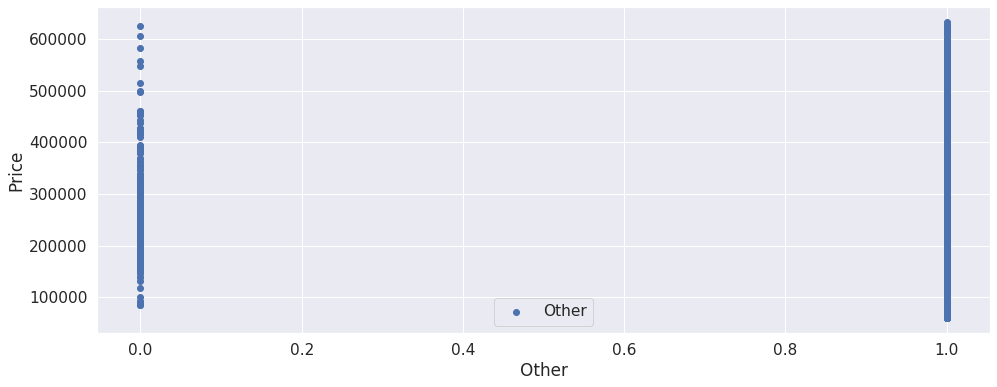

In [112]:
plt.figure(figsize=(16, 6))

plt.xlabel('Other')
plt.ylabel('Price')

# plt.plot(median_Ecology_1_by_dist_id['DistrictId'], median_Ecology_1_by_dist_id['Ecology_1'])
# plt.plot(median_Ecology_2_by_dist_id['DistrictId'], median_Ecology_2_by_dist_id['Ecology_2'])
# plt.plot(median_Ecology_3_by_dist_id['DistrictId'], median_Ecology_3_by_dist_id['Ecology_3'])
# plt.plot(median_Social_1_by_dist_id['DistrictId'], median_Social_1_by_dist_id['Social_1'])
# plt.plot(median_Social_2_by_dist_id['DistrictId'], median_Social_2_by_dist_id['Social_2'])
# plt.plot(median_Social_3_by_dist_id['DistrictId'], median_Social_3_by_dist_id['Social_3'])
# plt.plot(median_Helthcare_2_by_dist_id['DistrictId'], median_Helthcare_2_by_dist_id['Helthcare_2'])
# plt.plot(median_Shops_1_by_dist_id['DistrictId'], median_Shops_1_by_dist_id['Shops_1'])
# plt.plot(median_Shops_2_by_dist_id['DistrictId'], median_Shops_2_by_dist_id['Shops_2'])
plt.scatter(houses_train['Ecology_3'], houses_train['Price'])
# plt.legend(['Ecology_1', 'Ecology_2', 'Ecology_3'])
plt.legend(['Other', 'Price'])
plt.show()

# plt.xlabel('count')
# plt.ylabel('Признак')



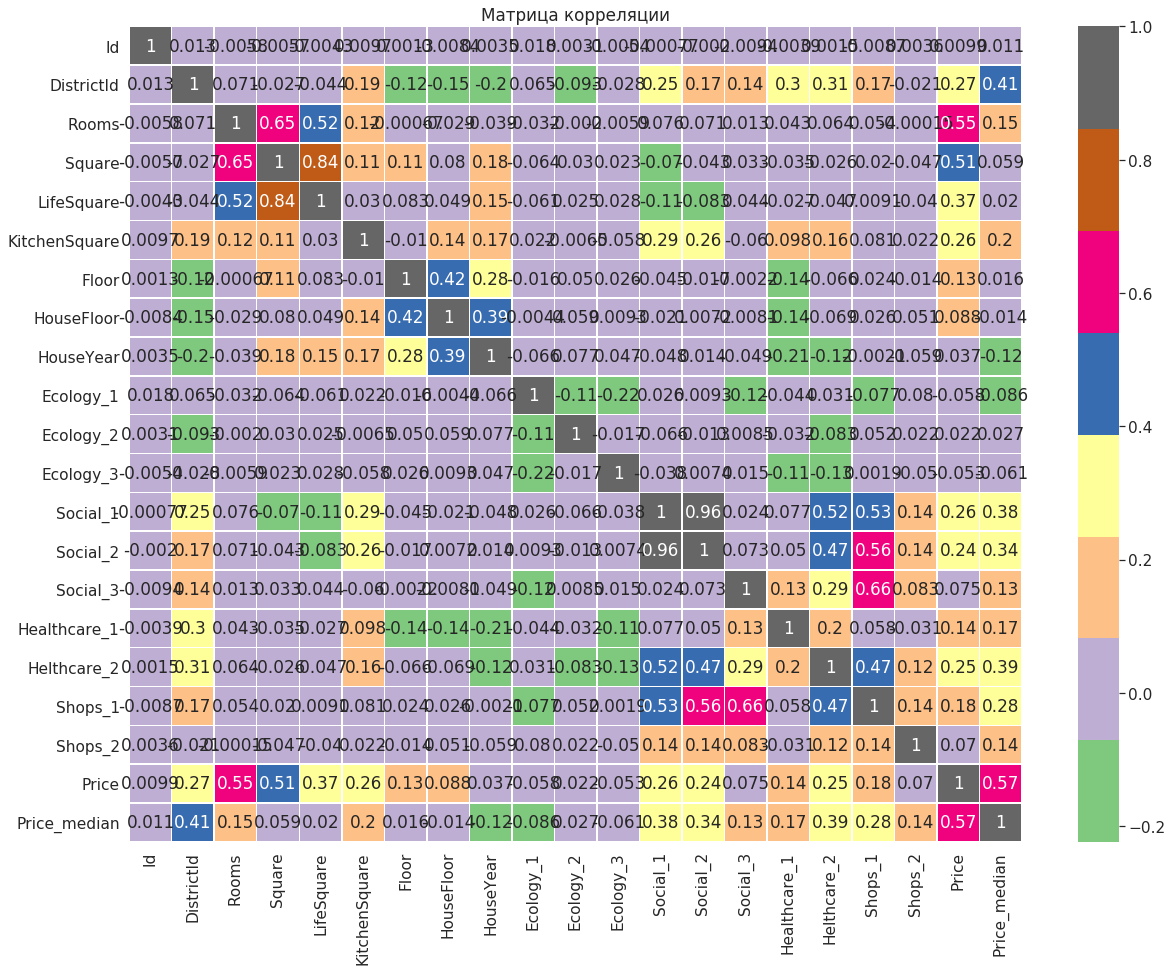

In [119]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(houses_train.corr(), annot=True, linewidths=.5, cmap='Accent')

plt.title('Матрица корреляции')
plt.show()

#### Замена пропусков в признаке LifeSquare
Проверим корректность данных в колонках, описывающих площадь: *Square*, *LifeSquare*, *KitchenSquare*. Признак *Square* должен быть больше чем *LifeSquare* и *KitchenSquare*. 

In [10]:
houses_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


Проверим аномальные значения LifeSquare: найдем значения LifeSquare, превышающие максимальное значение Square

In [11]:
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'].max())]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,1,1,2,469,0,NaN,0,0,1,217357.492366


Очистим это значение, далее обработаем его как пропуск

In [12]:
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'].max()), 'LifeSquare'] = None

Вычислим недостающие значения LifeSquare. Сначала найдем медианный коэффициент как отношение Square/LifeSquare. 

In [13]:
coeff_1 = pd.DataFrame()
coeff_1['s_ls'] = houses_train['Square'] / houses_train['LifeSquare']
coeff_1.describe()

,s_ls
count,7886.000000
mean,2.125775
std,4.474467
min,0.060471
25%,1.435224
50%,1.619435
75%,1.797851
max,166.648780


In [14]:
coeff_1['s_ls'].median()

1.6194346889143367

Вычислим недостающие значения LifeSquare как отношение Square / coeff_1

In [15]:
houses_train['LifeSquare'] = houses_train['LifeSquare'].fillna(houses_train['Square'] / coeff_1['s_ls'].median())
houses_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,10000.0,36.471016,19.141546,0.370619,24.238010,33.266172,44.872923,6.381632e+02
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


Проверим корректность данных в колонках, описывающих площадь: *Square*, *LifeSquare*, *KitchenSquare*. Признак *Square* должен быть больше чем *LifeSquare* и *KitchenSquare*. 

In [16]:
houses_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,10000.0,36.471016,19.141546,0.370619,24.238010,33.266172,44.872923,6.381632e+02
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [17]:
# LifeSquare > Square
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'])].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,1,1,0,168,0,NaN,0,0,1,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,1,1,1,264,0,NaN,0,1,1,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,1,1,53,13670,4,NaN,1,11,1,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,1,1,2,629,1,NaN,0,0,0,131797.472284


Предположим, что здесь они просто перепутаны и поменяем их местами, т.е. сделаем 
Square, LifeSquare = LifeSquare, Square

In [18]:
h1 = houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square']), ['LifeSquare']]
h2 = houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square']), ['Square']]
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square']), ['Square']] = h1['LifeSquare']
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square']), ['LifeSquare']] = h2['Square']

In [19]:
houses_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.483594,21.565423,2.377248,41.866858,52.633651,66.004634,6.410652e+02
LifeSquare,10000.0,36.471016,19.141546,0.370619,24.238010,33.266172,44.872923,6.381632e+02
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [20]:
# Проверим результат замены, должно быть 0 строк
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Проверим признаки KitchenSquare и Square, Square должно быть всегда больше KitchenSquare

In [21]:
houses_train.loc[(houses_train['KitchenSquare'] > houses_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,108337.484207
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,NaN,1,0,1,160488.033165
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,1,1,4,915,0,NaN,0,0,1,99079.960518
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275


Вычислим замену ошибочных значений KitchenSquare. Сначала найдем медианный коэффициент как отношение Square/KitchenSquare. 

In [22]:
coeff_1['s_ks'] = houses_train['Square'] / houses_train['KitchenSquare']
coeff_1['s_ks'].median()

8.28918821824032

In [23]:
houses_train.loc[(houses_train['KitchenSquare'] > houses_train['Square']), ['KitchenSquare']] = houses_train['Square'] / coeff_1['s_ks'].median()

In [24]:
# Проверим результат замены, должно быть 0 строк
houses_train.loc[(houses_train['KitchenSquare'] > houses_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Заменим DistrictId медианными значениями цены по каждому району, назовем его Price_median

In [25]:
median_price_by_dist_id = houses_train.groupby('DistrictId')[['Price']].median().reset_index()

In [26]:
houses_train = houses_train.merge(median_price_by_dist_id, on='DistrictId', how='left', suffixes=('', '_median'))

Снова разобъем выборку на train и test, удалив из нее: 
Healthcare_1
Price
DistrictId
Ecology_1
Shops_1
Helthcare_2
Shops_2
Ecology_3
Ecology_2

In [90]:
houses_train.loc[(houses_train['HouseYear'] == 20052011), ['HouseYear']] = 2011
houses_train.loc[(houses_train['HouseYear'] == 4968), ['HouseYear']] = 1968
houses_train[houses_train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_median


In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    houses_train.set_index('Id').drop(
        ['Healthcare_1',
#          'Helthcare_2',
         'Price', 
         'DistrictId', 
#          'Ecology_1', 
#          'Ecology_2', 
         'Ecology_3', 
#          'Shops_1', 
#          'Shops_2',
         'Social_1',
#          'Social_2',
#          'Social_3'
         ], axis='columns'), 
    houses_train['Price'], 
    test_size=0.25,
    random_state=123)

Обучаем

In [144]:
model_rfr = RandomForestRegressor(max_depth=16, n_estimators=175, random_state=123)
model_rfr.fit(X_train, y_train)
predict_1 = model_rfr.predict(X_test)
r2(y_test, predict_1)

0.7485333002741337

In [146]:
f_i = pd.DataFrame()
f_i['Name'] = houses_train.set_index('Id').drop(['Healthcare_1', 'Price', 'DistrictId', 'Ecology_3', 'Social_1'], axis='columns').columns.tolist()
f_i['Values'] = model_rfr.feature_importances_
f_i.sort_values('Values', ascending=False).reset_index(drop=True)

,Name,Values
0,Square,0.414105
1,Price_median,0.314193
2,Social_2,0.038302
3,HouseYear,0.032123
4,Rooms,0.031177
5,Social_3,0.029381
6,LifeSquare,0.029339
7,Floor,0.024275
8,KitchenSquare,0.023690
9,HouseFloor,0.022050


Загружаем тестовую выборку

In [147]:
houses_test = pd.read_csv('./test.csv')
houses_test.replace({'Ecology_2': {'A': 0, 'B': 1}, 'Ecology_3': {'A': 0, 'B': 1}, 'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
houses_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,NaN,0,0,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,NaN,3,3,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,NaN,0,0,0


In [148]:
houses_test = houses_test.merge(median_price_by_dist_id, on='DistrictId', how='left')

In [149]:
houses_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


In [151]:
houses_test = houses_test.rename(columns={"Price": "Price_median"})

Заполняем недостающие значения Price медианами

In [152]:
houses_test['Price_median'] = houses_test['Price_median'].fillna(houses_test['Price_median'].median())

Проверим аномальные значения LifeSquare: найдем значения LifeSquare, превышающие максимальное значение Square

In [153]:
houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square'].max())]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price_median
410,11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,1,1,25,6149,0,NaN,0,0,1,181706.718894


Очистим это значение, далее обработаем его как пропуск

In [154]:
houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square'].max()), 'LifeSquare'] = None

Вычислим недостающие значения LifeSquare. Сначала найдем медианный коэффициент как отношение Square/LifeSquare. 

In [155]:
coeff_1_test = pd.DataFrame()
coeff_1_test['s_ls'] = houses_test['Square'] / houses_test['LifeSquare']

In [156]:
houses_test['LifeSquare'] = houses_test['LifeSquare'].fillna(houses_train['Square'] / coeff_1_test['s_ls'].median())
houses_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,5000.0,35.953535,16.416670,0.333490,23.839100,32.996098,44.732170,169.901701
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


Проверим признаки KitchenSquare и Square, Square должно быть всегда больше KitchenSquare

In [157]:
houses_test.loc[(houses_test['KitchenSquare'] > houses_test['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price_median
1964,14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,202852.914457
2424,10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,1,1,31,6119,4,NaN,1,2,1,177936.020498
3863,3194,29,2.0,43.926987,31.028707,44.0,6,5.0,1964,0.086885,1,1,10,2277,2,1547.0,0,0,1,177936.020498
4555,12640,6,2.0,54.629142,31.486308,97.0,4,17.0,2015,0.243205,1,1,5,1564,0,540.0,0,0,1,168980.370846


Вычислим замену ошибочных значений KitchenSquare. Сначала найдем медианный коэффициент как отношение Square/KitchenSquare. 

In [158]:
coeff_1_test['s_ks'] = houses_test['Square'] / houses_test['KitchenSquare']
coeff_1_test['s_ks'].median()

8.297955962710592

In [159]:
houses_test.loc[(houses_test['KitchenSquare'] > houses_test['Square']), ['KitchenSquare']] = houses_test['Square'] / coeff_1_test['s_ks'].median()

Предсказание на следующей модели:  
 - Исключен признак с пропусками - Healthcare_1
 - DistrictId заменен медианными значениями цены (Price_median) по каждому району  
 - Заполнены недостающие данные по признаку LifeSquare
 - Исправлены значения LifeSquare и KitchenSquare, где KitchenSquare > Square и LifeSquare > Square
 - Исключены признаки 'Ecology_3', 'Social_1'

Подобранные гиперпараметры:  
'max_depth': 16,  
'n_estimators': 175

In [160]:
test_predict_6 = model_rfr.predict(houses_test.set_index('Id').drop(['Healthcare_1', 'DistrictId', 'Ecology_3', 'Social_1'], axis='columns')) 

In [161]:
houses_test['Price'] = test_predict_6

In [162]:
houses_test[['Id', 'Price']].to_csv('kaggle_20200826_1312.csv', index=False)